# Исследование данных о продажи видеоигр

**В данном исследовании нам доступны исторические данные о продажах игр, оценках пользователей и критиков, жанрах и платформах. На основании этих данных необходимо выявить закономерности, определяющие успешность игр в целом, а также имеющиеся зависимости в различных регионах покупателей.**
 
В ходе исследования мы внимательно изучим имеющиеся данные на предмет дубликатов, пропусков, некорректных значений и прочих аномалий. Также надо будет понять, какая часть этих данных может быть актуальна для прогнозов на будущее, а какая просто историческими данными не имеющими большого значения. В исследовательской части работы мы сравним показатели по разным игровым платформам, жанрам и регионам продаж, обратим внимание на динамику продаж игр в разные года, оценим влияние рейтингов и оценок. По основной части исследования будут сформулированы и проверены несколько статистических гипотез. 
 
 

## Обзор данных

Для начала загрузим данные и посмотрим, что мы имеем.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams["figure.figsize"] = 13, 6
import seaborn as sns


data = pd.read_csv("../datasets/games.csv")
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
pd.DataFrame(
    round(
        data.isna().mean() * 100,
    )
).style.background_gradient("gist_ncar_r")

,0
Name,0.000000
Platform,0.000000
Year_of_Release,2.000000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.000000
User_Score,40.000000


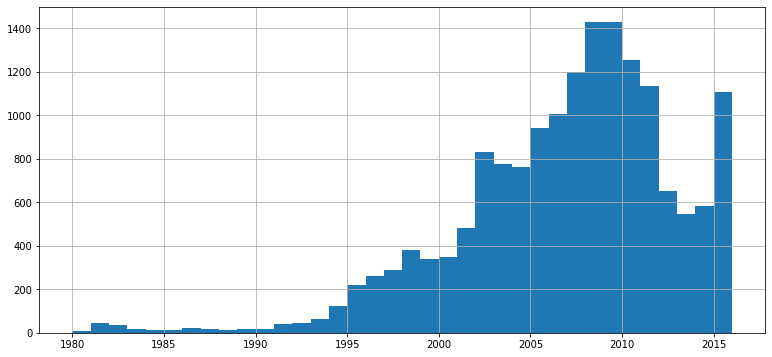

In [ ]:
data["Year_of_Release"].hist(bins=36);

В наличии мы имеем таблицу, содержащую 16715 строк, в которой находятся данные о характеристиках компьютерных игр с 1980 по 2016 год, величине их продаж в различных регионах и данные о рейтингах и оценках игр. <br>
*Также можно заметить, что названия столбцов в таблице имеют верхний регистр. Формат столбца `Year_of_Release` является дробным числом. А столбец `User_Score` имеет формат odject, хотя в нем находится числовая оценка. <br>
Относительно пропусков в значениях таблицы, можно заметить, что небольшое количество пропусков имеет столбец `Year_of_Release`, а также около 40-50% значений пропущено в столбцах `Critic_Score`, `User_Score` и `Rating` - возможно, это связано с тем, что часть игр в наших данных имеет порядочный возраст. Проверим это  в разделе* __Предобработка данных__


## Предобработка данных



### Обработка названий столбцов
Для начала приведем названия всех столбцов к привычному виду - заменим верхний регистр букв в названиях столбцов на нижний:

In [5]:
data.columns = data.columns.str.lower()

### Пропуски и формат столбца `year_of_release`
Теперь переведем значения столбца `year_of_release` во временной формат. Для этого, сначала, нам необходимо разобрабраться с пропусками в данном столбце. Так как пропуски составляют около 2х% и этот параметр важен для нашего исследования - избавимся от строк имеющих данный пропуск.

In [ ]:
data = data.dropna(subset=["year_of_release"])

In [ ]:
data["year_of_release"] = pd.to_datetime(data["year_of_release"], format="%Y")
data["year_of_release"] = pd.DatetimeIndex(data["year_of_release"]).year

In [ ]:
data["year_of_release"]

0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16446, dtype: int64

### Пропуски и значения столбцов `critic_score`, `user_score`, `rating`
Теперь оценим пропуски и значения в столбцах `critic_score`, `user_score` и `rating`.
Для начала проверим уникальные значения в каждом столбце на наличие каких-либо некорректных значений

In [ ]:
data["critic_score"].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [ ]:
data["rating"].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [ ]:
data["user_score"].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце с пользовательсткой оценкой компьютерных игр мы видим, что попадаются значения 'tbd' - чаще всего данное сокращение обозначает фразу *to be determined*, то есть - пока не определено. В нашим случае неопределенная оценка тоже самое, что пропуск. Поэтому заменим эти значения на обычный пропуск данных.

In [ ]:
data.loc[data["user_score"] == "tbd", "user_score"] = np.nan

Теперь можно заменить формат значений в этом столбце на числовой формат. Для удобства анализа переведем оценки в 100-бальную систему и установим числовой формат.

In [ ]:
data["user_score"] = data["user_score"].astype("float")
data["user_score"] = data["user_score"] * 10

В значениях  с рейтингами и оценками мы имеем около 50% неоценненых игр из нашей таблицы. Скорее всего это небольшие игры от малоизвестных производителей, которые так и не вышли на широкий рынок, поэтому не были удостоены оценкам и рейтинги для них не составлялись; также это может быть применимо к старым играм, когда не было широкой возможности собирать оценки пользователей и критиков, а рейтинговое агенство еще не существовало (до 1994). Проверим теорию о том, что пропуски в столбцах `critic_score`, `user_score` и `rating` содержаться по большей части в одних и тех же играх. Для этого оценим количество игр, имеющих пропуски во всех 3х столбцах с количеством пропусков в столбце `rating`

In [ ]:
print(data["rating"].isna().sum())
data.loc[
    (data["critic_score"].isna())
    & (data["user_score"].isna())
    & (data["rating"].isna())
].shape[0]

6678


6582

Теория подтвердилась - игры не имеющие возрастного рейтинга, в большинстве своем, не имеют также и оценки пользователей и критиков.<br>
Заполнение такого большого количества пропусков явно даст отрицательное влияние на последующее исследование. Поэтому не будем заполнять пропуски, а для последующего сравнения параметров, содержащих данные столбцы, создадим датафрейм со значениями исходной таблицы, которые не содержат пропусков в столбцах `critic_score` и `user_score`. По поводу пропусков в столбце `rating` - чтобы в последующем анализе можно было учесть игры без рейтинга и видеть их распределение по регионам, заменим пропуски в этом столбце на значение `'zero'`.

In [ ]:
data["rating"] = data["rating"].fillna("zero")

### Проверка на дубликаты
Проверим наши данные на наличие дубликатов

In [16]:
data.duplicated().sum()

0

### Столбец `all_sales`
Добавим столбец с суммарными продажами каждой игры по всем регионам

In [ ]:
data["all_sales"] = data[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum(
    axis=1
)

## Исследовательский анализ данных

### Анализ года выпуска игры
Посмотрим как распределены игры по годам их выпуска.

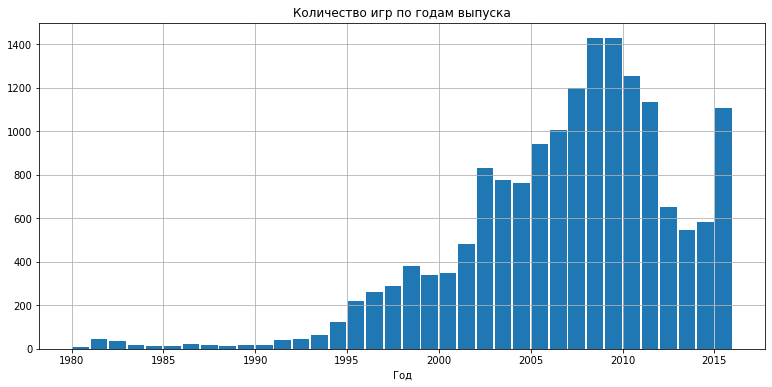

In [ ]:
ax = data["year_of_release"].hist(bins=36, rwidth=0.9)
ax.set_title("Количество игр по годам выпуска")
ax.set_xlabel("Год");

Мы видим, что количество выпускаемых игр в год значительно выросло со временем, при этом пик выпуска приходился на 2007-2011 года. Далее наблюдается некоторый спад в количестве, однако не менее 500 игр каждый год появляются на свет. По графику видно, что в большой временной промежуток с 1980го по 2002 выпускалось небольшое количество игр в сравнении с последними десятью годами, также это были годы развития данной области, появлялись новые технологии и платформы. Пользоваться такими старыми данными для прогнозирования результатов на ближайшие годы является некорректным. 

### Анализ распределения платформ выпуска игр

Так как мы имеем данные примерно за 35 лет, то логично допустить, что некоторые платформы к настоящему моменту перестали существовать или сменились следующей версией. Посмотрим на распределение выпуска игр по годам в зависимости от той платформы на которую их делали.



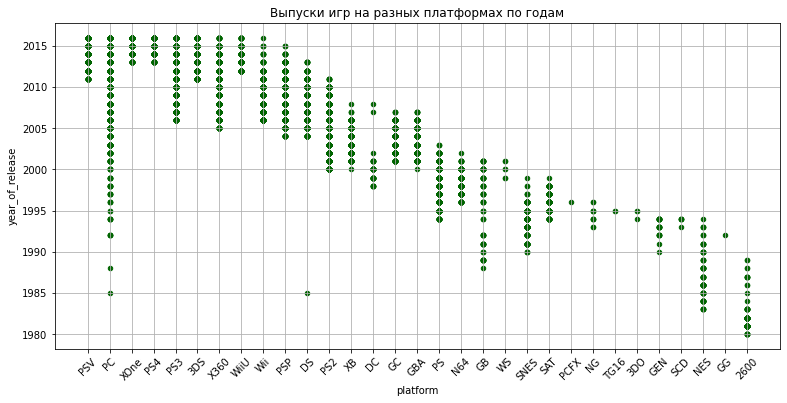

In [ ]:
ax = data.sort_values(by="year_of_release", ascending=False).plot(
    kind="scatter",
    x="platform",
    y="year_of_release",
    rot=45,
    grid=True,
    color="DarkGreen",
    title="Выпуски игр на разных платформах по годам",
)

По данному графику хорошо видно, что на большую часть платформ игры уже давно не выпускаются, и соответственно, рассчитывать на эти платформы в будущем смысла нет. Также можно заметить, что в среднем платформы поддерживают выпуск игр в течении примерно 10 лет, за исключением PC, который остается постоянно актуальным. Если рассматривать теорию о 10ти летнем сроке выпуска игр на каждую платформу, то можно заметить, что такие платформы как PS3, X360, Wii и PSP заканчивают период в котором на них выпускают игры и сильно рассчитывать на эти платформы в будущем не стоит. <br>
Теперь рассмотрим какие из платформ приносили наибольшее количество проданных копий за время выпуска игр на них.


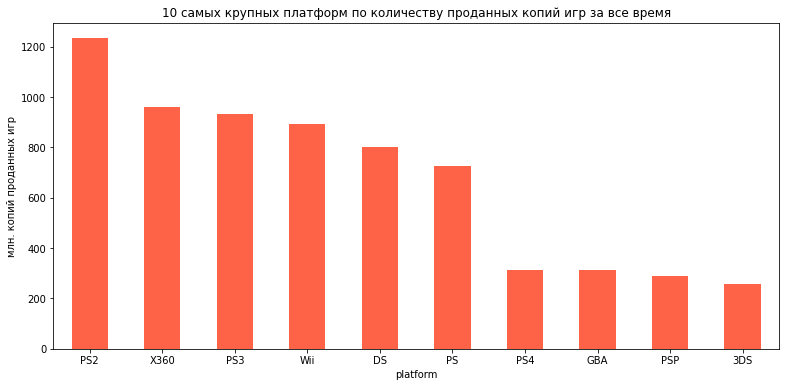

In [ ]:
ax = (
    data.groupby("platform")["all_sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot.bar(
        rot=0,
        title="10 самых крупных платформ по количеству проданных копий игр за все время",
        color="tomato",
    )
)
ax.set_ylabel("млн. копий проданных игр");

Как видно по графику, основные платформы по продажам - это платформы серии PlayStation, Xbox и Nintendo таких поколений, которые прожили свой жизненый цикл выпуска игр (около 10ти лет) или находятся на грани этого периода PS2, PS3, X360, Wii. Свежие поколения этих платформ, такие как PSV, Xone, PS4, 3DS и WiiU еще не появились в лидерах по количеству проданных копий игр. <br>
Также можно заметить, что игры для PC не находятся в первой 10ке по количеству проданных копий, не смотря на то, что платформа является большим "долгожителем".


**Исходя из полученных результатов можно сделать вывод, что для дальнейшего исследования и составления прогноза на следующий год нет необходимости использовать данные за все годы. Поэтому отбросим данные по играм выпущенным до 2010 года, таким образом у нас будет информация о динамики спроса на игры на все актуальные платформы к текущему моменту и минимум лишней информации.**

In [ ]:
data = data.query("year_of_release >= 2010")

### Изучения динамики продаж для разных платформ
На выбранных данных рассмотрим как менялись количества проданых копий игр в зависимости от платформы и года


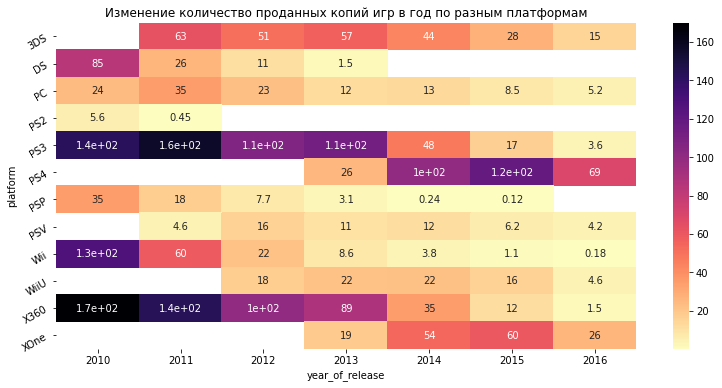

In [ ]:
df = data.pivot_table(
    index="platform", columns="year_of_release", values="all_sales", aggfunc="sum"
)

ax = sns.heatmap(data=df, annot=True, cmap="magma_r")
ax.set_title("Изменение количество проданных копий игр в год по разным платформам")
ax.tick_params(axis="y", labelrotation=30);

По тепловой карте заметно, что на всех игровых платформах, существующих в 2011 году происходит общий спад в продажах игр с каждым годом. Необходимо помнить, что за 2016 год мы имеем неполные данные по продажам и аккуратнее делать выводы по этому году. Также видно, что часть продаж перехватывают платформы, которые только появились, в частости XOne, PS4 и WiiU. При этом платформа WiiU уже начинает терять высокие обороты продаж и к настоящему времени идет на спад. <br>
__Таким образом мы видим высокий потенциал 2х платформ - XOne и PS4, а также несколько платформ из давно существующих, но еще имеющих не низкий уровень продаж игр - это PC и 3DS.__

Построим также диаграмму размаха общей выручки от каждой игры отдельно по всем платформам <a id='1'></a>

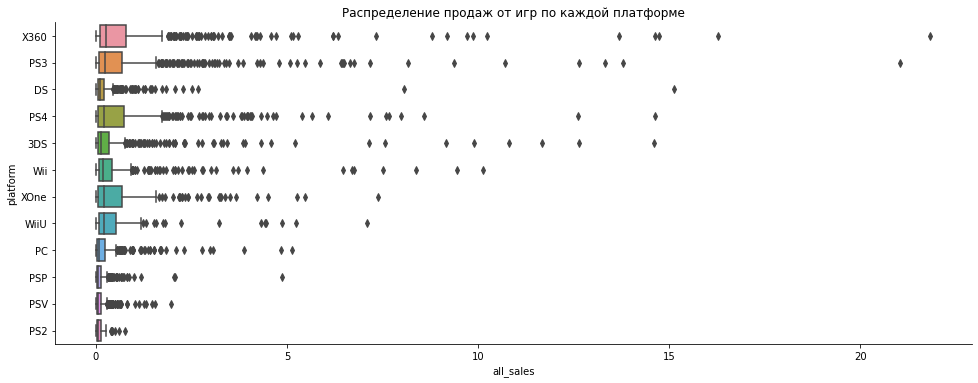

In [ ]:
sns.catplot(
    data=data, x="all_sales", y="platform", kind="box", orient="h", height=5, aspect=2.7
).set(title="Распределение продаж от игр по каждой платформе");

По данной диаграмме можно сказать, что большинство игр приносят каждой платформе не самые большие продажи, а гораздо большее влияние оказывают отдельные сверх-популярные игры, копии которых продаются в разы чаще основной массы игр. При этом по данной диаграмме невозможно сравнить медианные величины количества продаж по разным платформам, сделаем дополнительный график с акцентом на интересующий период.

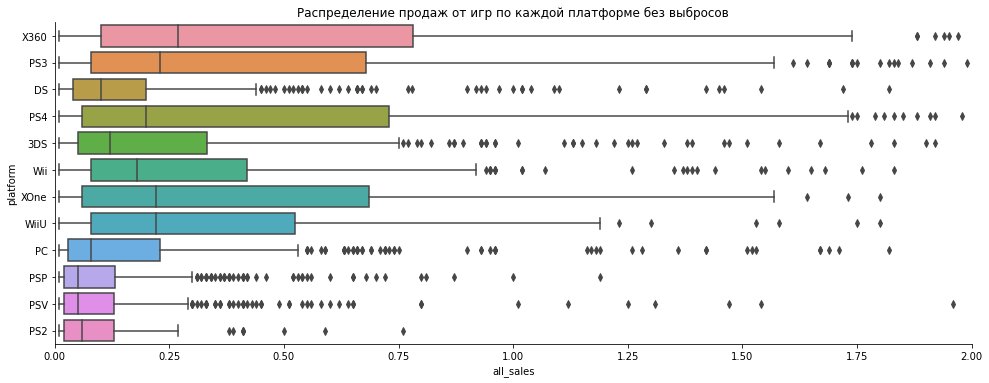

In [ ]:
ax = sns.catplot(
    data=data, x="all_sales", y="platform", kind="box", orient="h", height=5, aspect=2.7
).set(title="Распределение продаж от игр по каждой платформе без выбросов")
ax.set(xlim=(0, 2));

По данному распредению можно сказать, что лидирующие позиции в медианном количестве продаваемых копий игр является платформа Xbox360, то есть в среднем для этой платформы игры продаются успешнее. 5-ка платформ с высокими средними продажами игр выглядит так - Xbox360, PS3, WiiU, XOne и PS4 - То есть игры передовых серий платформ XBox, PlayStation и Nintendo(WiiU) в среднем имеют высокие успехи. При этом можно обратить вниминие, что платформа 3DS имеющая хорошие годовые продажи, не выделяется в медианном количестве продаж игр, и , как следствие, собирает продажи за счет количества игр или за счет отдельных сверх-успешных игр.

### Исследование влияния оценок игр пользователями и критиками

Для оценки влияния рейтингов и оценок игр на их продажи возьмем из наших данных только те, что не имеют пропусков в столбцах `critic_score` или `user_score`.

In [ ]:
score_table = data[(data["critic_score"].notna()) & (data["user_score"].notna())]

Рассмотрим как оценки пользователей и критиков влияют на количество проданных копий игр. Для наглядности выберем несколько популярных игровых платформ - PS4, XOne и WiiU.

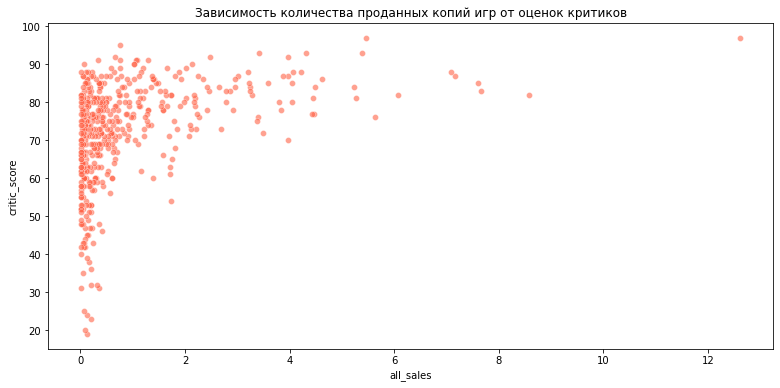

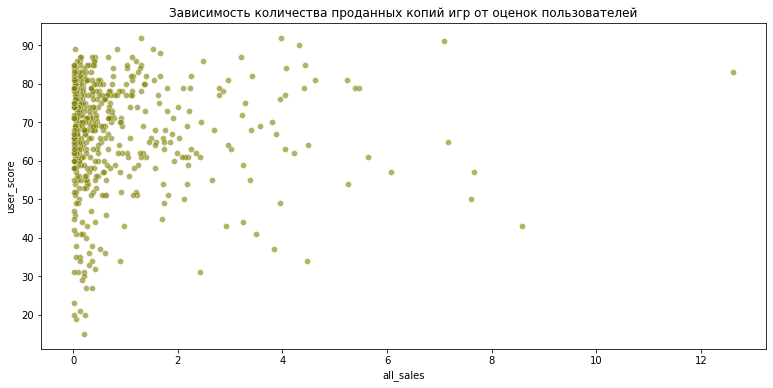

In [ ]:
ax1 = sns.scatterplot(
    data=score_table.query(
        'platform == "PS4" or platform == "XOne" or platform == "WiiU"'
    ),
    x="all_sales",
    y="critic_score",
    color="tomato",
    alpha=0.6,
)
ax1.set_title("Зависимость количества проданных копий игр от оценок критиков")
plt.show()
ax2 = sns.scatterplot(
    data=score_table.query(
        'platform == "PS4" or platform == "XOne" or platform == "WiiU"'
    ),
    x="all_sales",
    y="user_score",
    color="olive",
    alpha=0.6,
)
ax2.set_title("Зависимость количества проданных копий игр от оценок пользователей")
plt.show()

Также рассчитаем коэфициент корреляции между параметрами количества проданных копий и оценками пользователей и критиков на выбранных платформах

In [ ]:
score_table.query(
    'platform == "PS4" or \
                  platform == "XOne" or \
                  platform == "WiiU"'
)[["user_score", "critic_score", "all_sales"]].corr().style.background_gradient(
    "gray_r"
)

,user_score,critic_score,all_sales
user_score,1.000000,0.555029,0.015552
critic_score,0.555029,1.000000,0.383756
all_sales,0.015552,0.383756,1.000000


По полученным графикам можно сказать, что количество проданных копий игр очень слабо зависит от каких-либо оценок, в частости мы видим полное отсутствие зависимости между пользовательской оценкой и результатом продаж. Оценка критиков коррелирует с продажами тоже очень слабо, однако по диаграмме рассеивания можно заметить, что игры с оценками критиков меньше 60 точно не продавались в какой-либо значимой степени. При этом если оценка критиков игры забралась выше 70, то у игры есть шанс стать прибыльной, а если оценка выше 90, то игра явно должна "выстрелить". По оценкам пользователей сложно строить какие-либо теории, кроме той, что если игра набрала меньше 30, то ждать от нее больших результатов по продажам не приходится.

**Смотря на [распределение](#1) продаж игр по платформам, мы видим схожую, в большей степени, ситуацию относительно разных платформ - основные игры продаются в небольших тиражах и отдельные экземпляры приносят бОльшую часть продаж. При этом смотря на распределение оценок критиков и количества продаваемых копий игр можно предположить, что именно эти игры имееют оценку критиков > 70.**

### Анализ влияния жанра игры на ее успешность и популярность.

Для начала посмотрим как распределяются игровые жанры среди всего множества игр, а также какую прибыль приносили разные жанры игр за весь рассматриваемый период.

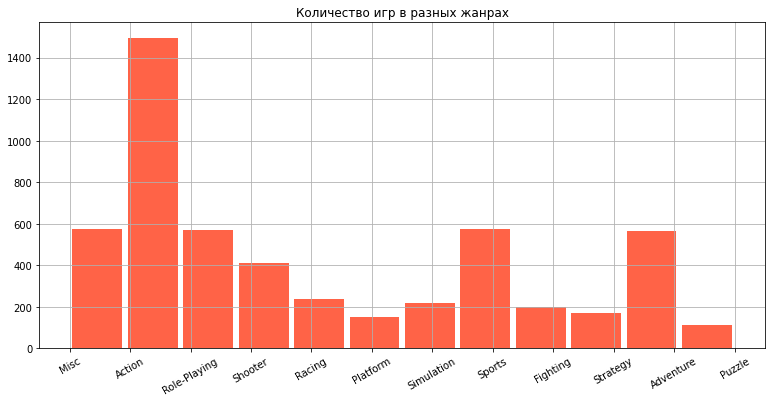

In [ ]:
ax = data["genre"].hist(bins=12, rwidth=0.9, color="tomato")
ax.set_title("Количество игр в разных жанрах")
ax.tick_params(axis="x", labelrotation=30);

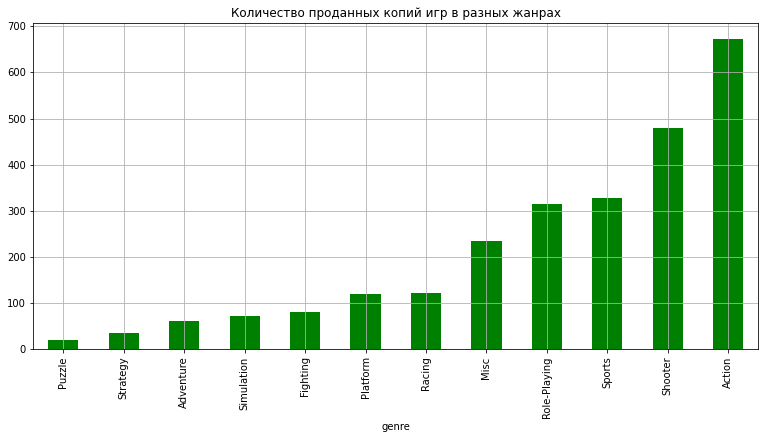

In [ ]:
(
    data.groupby("genre")["all_sales"]
    .sum()
    .sort_values()
    .plot(
        kind="bar",
        colormap="ocean",
        grid=True,
        title="Количество проданных копий игр в разных жанрах",
    )
);

Чтобы понять игры какого жанра имееют большую успешность в продажах сделаем такой же график только по медианным значениям продаж игр каждого жанра.

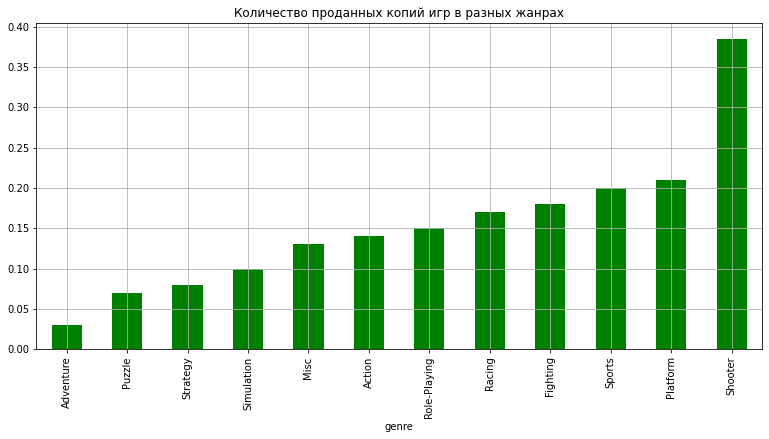

In [ ]:
(
    data.groupby("genre")["all_sales"]
    .median()
    .sort_values()
    .plot(
        kind="bar",
        colormap="ocean",
        grid=True,
        title="Количество проданных копий игр в разных жанрах",
    )
);

По данным графикам мы видим интересное распределение:
- Cамый популярный жанр в суммарных продажах - это Action, при этом он обгоняет всех по количеству игр более чем в 2.5 раза, однако средние продажи игр в этом жанре даже не попадают в 5-ку лидеров по средним продажам. Отсюда можно сделать вывод, в жанре Action продажи собираются за счет количества выпускаемых игр;
- Интересную картину показывает жанр Shooter - находясь на 6-ом месте по распределению игр он имеет 2-ое место по общим продажам среди остальных жанров, и является абсолютным лидеров по средним продажам игр, почти в 2 раза превышая средние продажи в других жанрах;
- Следующие 4 жанра по популярности это - Adventure, Sports, Role-Playing и Misc. Они имеют примерно равное распределение количества игр, однако результаты их продаж различаются. Тут мы сразу видим аутсайдера- жанр Adventure, который значительно отстал по продажам в абсолютном и среднем значении от остальных. Жанр Sports имеет самые высокие средние продажи среди этой 4-ки жанров. Остальные Role-Playing и Misc немного отстают в среднем уровне продаж;
- Также надо обратить внимание, что жанры Platform, Flaying и Racing находятся в 5-ке жанров по средним продажам игр, хотя популярность выпуска игр на них небольшая.

Дополнительно рассмотрим как менялась динамика средних продаж по годам в 5ке самых популярных жанров по выпускам игр за последнее время. Это будут жанры Action, Shooter, Sports, Role-Playing и Misc в порядке убывания.

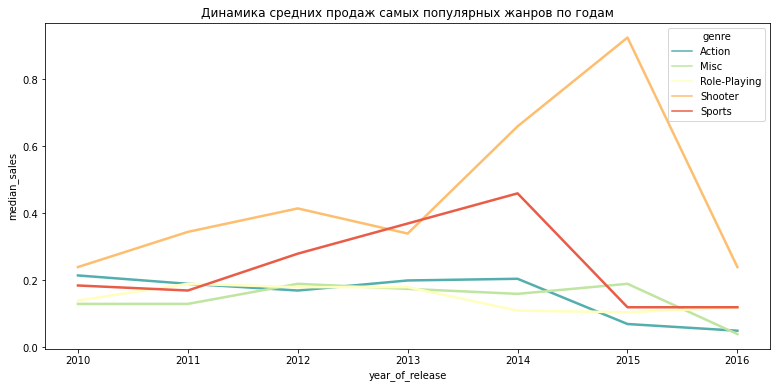

In [ ]:
data_pop_genre = data.query(
    'genre=="Action" or \
                            genre=="Shooter" or \
                            genre=="Sports" or  \
                            genre=="Role-Playing" or \
                            genre=="Misc"'
).pivot_table(
    index="year_of_release", columns="genre", values="all_sales", aggfunc="median"
)

ax = sns.lineplot(data=data_pop_genre, dashes=False, palette="Spectral_r", lw=2.5)
ax.set_title("Динамика средних продаж самых популярных жанров по годам")
ax.set_ylabel("median_sales");

Дополнительно к прошлым выводам можно добавить, что с 2010 года средние продажи жанров Action, Role-Playing и Misc несущественно изменяются, хотя жанр Action после 2014 начал терять позиции. Средние продажи жанра Sport изменяются нестабильно сильно от года к году. А средние продажи жанра Shooter практически весь рассматриваемый период имеют лидерство среди остальных популярных жанров.

### Исследование предпочтений и продаж в играх относительно региона.

Для начала, посмотрим на самые популярные платформы и жанры в имеющихся регионах. Рассматриваемые регионы это - NA, EU и JP - Северная Америка, Европа и Япония соответственно.

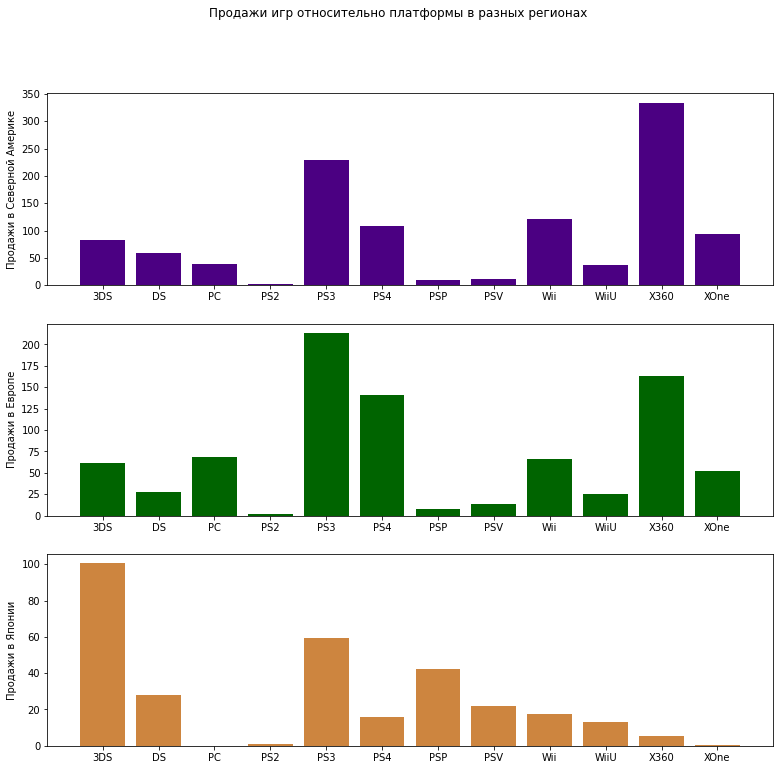

In [ ]:
df_plf = data.groupby("platform").sum()

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle("Продажи игр относительно платформы в разных регионах")
fig.set_figheight(12)
ax1.bar(df_plf.index, df_plf["na_sales"], color="indigo")
ax1.set_ylabel("Продажи в Северной Америке")
ax2.bar(df_plf.index, df_plf["eu_sales"], color="DarkGreen")
ax2.set_ylabel("Продажи в Европе")
ax3.bar(df_plf.index, df_plf["jp_sales"], color="peru")
ax3.set_ylabel("Продажи в Японии");

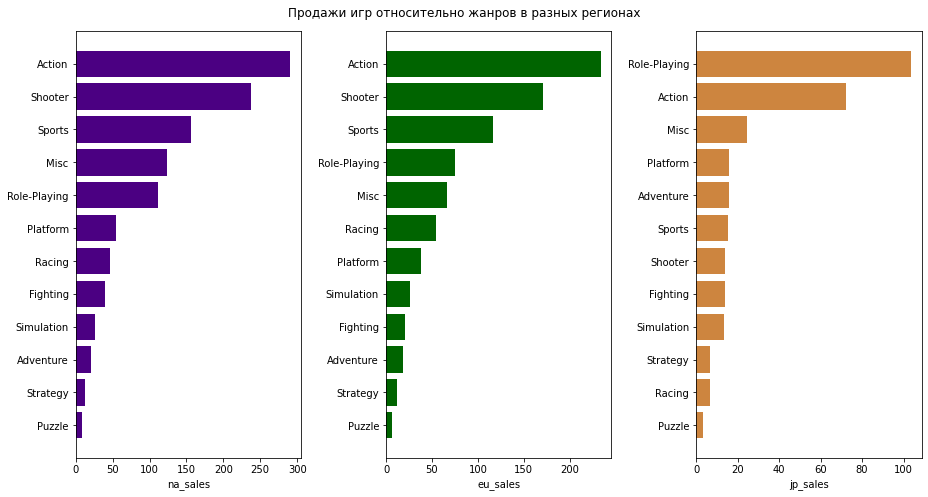

In [ ]:
df_gnr = data.groupby("genre").sum()
fig, axs = plt.subplots(1, 3)
fig.suptitle("Продажи игр относительно жанров в разных регионах")
fig.set_figheight(7)
fig.set_figwidth(13)
j = 0
color = ["indigo", "DarkGreen", "peru"]

for i in ["na_sales", "eu_sales", "jp_sales"]:
    ax = axs[j]
    dfi = df_gnr.sort_values(by=i)
    ax.barh(dfi.index, dfi[i], color=color[j])
    ax.set_xlabel(i)
    j += 1

fig.tight_layout()

По полученным данным можно сделать отдельные выводы для каждого региона.
1. Северная Америка: <br>
Для Северной Америки любимые 5 игровых платформ это - Х360, PS3, Wii, PS4 и XOne. При этом Х360 является лидером по количеству проданных копий игр и огоняет ближайшего конкурента PS3 примерно в полтора раза. Это частично можно объяснить тем, что родиной этой платформы является американская корпорация. Остальные любимые Америкой платформы Wii, PS4 и XOne отстают от PS3 почти в 2 раза и имееют схожий уровень продаж, при этом необходимо помнить, что в рассматриваемом периоде платформа Wii существует в 2 раза дольше платформ PS4 и XOne. <br>
Самые популярные жанры в Северной Америке это - Action, Shooter, Sports, Misc и Role-Playing в порядке убывания. При этом жанр Action явно лидирует в продажах с отрывом как минимум в 2 раза от остальных популярных жанров, исключая жанр Shooter, который "дышит ему в спину" и занимает 2ое место.


2. Европейский регион:<br>
В Европейском регионе мы видим чуть отличное распределение популярных игровых платформ от Америки. Здесь 5ка лидеров выглядит так - PS3, X360, PS4, PC и Wii. Платформа PS3 является лидером по продаже игр. По графику можно заметить, что для Европейского региона характерны продажи игр в большей части на 3 платформы - PS3, X360 и PS4, остальные платформы отстают от них как минимум в 2 раза. Платформы PC и Wii из пятерки лидеров по количеству продаж практически не выделяются от продаж платформ 3DS и XOne, которые не попали в 5ку. <br>
Распределение жанров в европейском регионе очень схоже с Американским регионом. Лидером является жанр Action, разве что его отрыв от остальных чуть более увеличен. 2-ое и 3-е место также достались жанрам Shooter и Sports, а на 4ом и 5ом месте те же жанры Misc и Role-Playing, но в другом порядке.


3. Япония:<br>
В Японии мы видим совсем другое распределение популярных платформ и жанров. Здесь лидирующая 5-ка платформ выглядит так - 3DS, PS3, PSP, DS и PSV. Всё это японские производители, американская линейка XBox здесь находится в отстающих позициях, также как и игры на персональный компьютер (PC) совершенно не востребованы в Японии. Явный лидер среди платформ компьютерных игр здесь - 3DS, имеет количество проданых копий игр в 2-3 раза превышающих остальные платформы. На втором месте по популярности платформа PS3 - данная платформа прочно держится в лидерах на любых континентах. Можно отметить, что в Японии в 5-ку лидеров лидеров попала платформа PSP, которая в остальных регионах не имеет значимой популярности. <br>
Среди популярных жанров в Японии тоже картина совершенно непохожая на остальные регионы. Здесь мы видим выдающиеся продажи в жанре Role-Playing. Следом за ним идет популярный в остальных регионах жанр Action. Остальные жанры компьютерных игр имееют популярность значительно ниже, в 3-4 раза, относительно лидеров Role-Playing и Action. Среди остальных жанров немного выделяется своими продажам жанр Misc.


### Анализ влияния рейтинга ESRB на продажи игр в разных регионах
Рассмотрим как игры с различными возрастными рейтингами от организации ESRB продавались по отдельным регионам продаж.

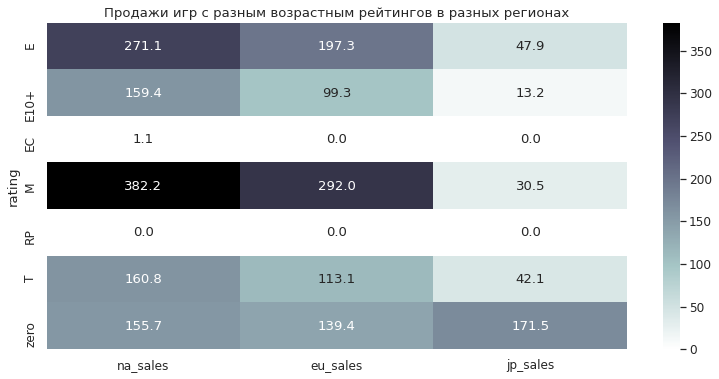

In [ ]:
sns.set(font_scale=1.1)
sns.heatmap(
    data=data[["rating", "na_sales", "eu_sales", "jp_sales"]].groupby("rating").sum(),
    cmap="bone_r",
    fmt=".1f",
    annot=True,
).set(title="Продажи игр с разным возрастным рейтингов в разных регионах");

Как видно по полученной таблице в Северо-американском и Европейском регионах самыми продаваемыми играми являются игры с возрастным рейтингом "М", на втором месте по продажам в этих регионах находятся игры с рейтингом "Е" - так как этот рейтинг "для всех" свою популярность он может получать за счет широкого возрастного диапозона геймеров. И в целом, разброс продаж в этих регионах является схожим. Игры без рейтинга ESRB популярны в Европейском регионе даже больше, чем игры с любыми рейтингами, кроме "М" и "Е". На Американском рынке игры без рейтинга имееют популярность схожую с играми имеющими подростковые рейтинги (Е10+, Т). <br>
В Японии мы видим совсем другое распределение популярности игр относительно рейтинга ESRB. Здесь самыми продаваемыми являются игры без рейтинга ESRB. А взрослый рейтинг "М", здесь совсем не выделяется по количеству продаж. Также можно заметить что игры с рейтингом "Е" на всех континентах имееют стабильное второе место по популярности, хоть и с разным отрывом от первого места в зависимости от региона.<br>

*Здесь так же важно отметить, что организация ESRB имеет свои корни и большЕе влияние на территории Северной Америки. Для Японии, насколько мы видели выше, характерны другие типы платформ и жанров игр, также там присутствуют собственные рейтинговые компании (например CERO). Поэтому велик шанс, что игры, не имеющие рейтинга ESRB и настолько популярные в Японии, были созданы специально для этого рынка и имеют возрастной рейтинг, полученный в другом рейтинговом агенстве.*


## Статистические проверки гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC

Проверим гипотезу о равенстве средних пользовательских рейтингов компьютерных игр на таких платформах как Xbox One и PC.

Для начала сформулируем нулевую гипотезу - средние рейтинги пользователей на платформах XOne и РС равны.<br>
Тогда альтернативная гипотеза - средние рейтинги пользователей на платформах XOne и РС  не равны. <br>
Для проверки гипотез будем использовать двухсторонний t-тест методом `ttest_ind`, так как мы имеем 2 выборки из разных генеральных совокупностей (совокупности оценок пользователей разных игровых платформ). <br>
Количество игр на платформах XOne и РС различается, поэтому будем выставлять показатель равенства дисперсий 2х выборок равный `False`. 


In [ ]:
alpha = 0.05
ar_XOne = score_table.query('platform == "XOne"')["user_score"]
ar_PC = score_table.query('platform == "PC"')["user_score"]

results = st.ttest_ind(ar_PC, ar_XOne, equal_var=False)

if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу, pvalue={results.pvalue}")
else:
    print(f"Не получилось отвергнуть нулевую гипотезу, pvalue={results.pvalue}")

Не получилось отвергнуть нулевую гипотезу, pvalue=0.9127457287129151


__Из-за высокого уровня значимости отвергнуть нулевую гипотезу не удалось, тогда можно сделать вывод о значимом равенстве между средними пользовательскими оценками игр на платформах Xbox One и PC.__

### Средние пользовательские рейтинги жанров Action  и Sports 
Проверим гипотезу о том, что средние пользовательские рейтинги компьютерных игр в жанрах  Action  и Sports различаются.


Для начала сформулируем нулевую гипотезу - cредние рейтинги пользователей в жанрах Action и Sports равны. <br>Тогда альтернативная гипотеза - cредние рейтинги пользователей в жанрах Action и Sports различаются.<br>
Для проверки гипотез будем снова использовать двухсторонний t-тест методом `ttest_ind`, так как мы имеем 2 выборки из разных генеральных совокупностей (совокупности оценок пользователей разных игровых жанров).<br>
Количество игр в жанрах Action и Sports существенно различается, поэтому будем выставлять показатель равенства дисперсий 2х выборок равный False. 

In [ ]:
alpha = 0.05
ar_Act = score_table.query('genre == "Action"')["user_score"]
ar_Sport = score_table.query('genre == "Sports"')["user_score"]

results = st.ttest_ind(ar_Sport, ar_Act, equal_var=False)

if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу, pvalue={results.pvalue}")
else:
    print(f"Не получилось отвергнуть нулевую гипотезу, pvalue={results.pvalue}")

Отвергаем нулевую гипотезу, pvalue=8.946726392720106e-10


__Полученный уровень значимости очень низкий, соответственно нулевую гипотезу придется отвергнуть. Зато мы имеем четкое подтверждение нашей гипотезы о том, что средние пользовательские рейтинги компьютерных игр в жанрах Action и Sports различаются статистически значимо.__

## Общие выводы

В проведенном исследовании мы изучили исторические данные о продажах компьютерных игр, искали среди данных закономерности, определяющие успешность компьютерных игр в целом, а также зависимости от различных параметров. <br>
В работе нам пришлось обработать данные от пропусков, некорректных форматов значений и прочих аномалий. Для актуальности и точности исследования пришлось отбросить часть данных, не имеющих в настоящее время исследовательской ценности. В ходе исследования мы изучили влияние на количество продаваемых копий игры таких параметров как: платформа на которую выпускали игру, жанр игры, оценки и рейтинги игр. Рассмотрели предпочтения пользователей из различных регионов в игровых жанрах и платформах. В конце исследования были проверены несколько статистических гипотез, сформированных в ходе исследования.



По полученным результатам исследования можно сказать следующее:
- Срок выпуска игр под игровую платформу составляет около 10 лет, и в течении условно последних 2х лет продажи игр под эту платформу начинают падать. По этой причине на данный момент перспективными платформами в Европейском и Американском регионе являются XOne и PS4 набирающие количество продаж с каждым годом все больше. При этом надо помнить, что платформа серии Xbox совсем не имеет популярности в Японии. Также платформа 3DS продолжает показывать хорошие продажи за счет Японского региона;
- Выпуски игр под платформу PC представляются стабильными и небольшими в Европейском и Америнском регионах на промежутки большого количества лет;
- Можно сказать, что большинство игр имеет не значительный уровень продаж, поэтому можно обратить внимание на вероятность того, что игры, оцененые критиками на более чем 70 баллов, имееют шанс стать предметом больших продаж. При оценке критиков более 90 - мы имеет будущую звезду продаж;
- Среди жанров игр можно выделить явного лидера - Shooter. Имея не самое передовое количество игр, данный жанр имеет очень высокий уровень продаж, который слабо изменяется от года в год. Стоит только отметить посредственную популярность данного жанра в Японии;
- В каждом регионе можно выделить популярный жанр Action, однако за счет большого количества игр в данном жанре будет сложнее отобрать потенциально выгодную, тут могут помочь оценки критиков, при их наличии;
- По Японскому региону можно отметить самый популярный жанр Role-Playing, в сочетании с популярной в Японии платформой 3DS или перспективной РS4 можно получить выгодную комбинацию;
- При этом в Американском и Европейском регионе большинсво прибыльных игр имеют возрастной рейтинг от ESRB "М", в Японии с рейтингами ESRB все сложнее, большинство игр продается без этого рейтинга.

**По данным результатам, для требуемого региона можно подобрать набор параметров, который с большой вероятностью принесет магазину хорошие продажи и обеспеченное будущее!**



